# Mapping Swiss Ecosystems from Aerial Images and Environmental Variables

This notebook presents the analyses and data pipeline for the project.  
It demonstrates that this pipeline is fully reproducible and provides a systematic workflow for mapping ecosystems in Switzerland using both aerial imagery and environmental variables.


---

## 📂 Project Folder Structure

**Root project folder:** `project/`

- `data/`
  - `images.zip/`            ← Aerial images, named by ID (e.g., 2572824_1174283.tif)  
  - `dataset_split.csv`  ← Tabular data with IDs, split, SWECO variables, EUNIS labels
- `utils/`  
  - `eunis_labels.py`                  ← Mapping from numeric ID to EUNIS label  
  - `sweco_group_of_variables.py`      ← SWECO variable thematic groups
- `figures/`                 ← Save different plot
- `models/`                   ← Save the best model for different architecture and parameters
- `ipeo_project.ipynb` ← Notebook: pipeline, results, plots, discussion
- `inference.ipynb` ← Notebook: test the best model on a few samples of the test set
- `experiment_log.csv` ← CSV to store performance for different models and hyperparameters
- `README.md` ← Project overview, instructions, dependencies  
- `pip_requirements.txt` ← Python dependencies  

---

## 🧭 Table of Contents

1. [Header & Setup](#1)

2. [Introduction](#2)  
   2.1 [Context and Motivation](#21)  
   2.2 [Objectives of the Project](#22)

3. [Data Loading & Description](#3)  
   3.1 [Overview of the Dataset](#31)  
   3.2 [Data loading](#32)  
   3.3 [Check & Clean SWECO Variables](#33)  
   3.4 [Train / Validation / Test Split](#34)  
   3.5 [Ecosystem Labels (EUNIS)](#35)  
   3.6 [Environmental Variables (SWECO25)](#36)  
   3.7 [Aerial Images Overview](#37)

4. [Data Preprocessing](#4)  
   4.1 [Image Preprocessing](#41)  
   4.2 [Tabular Data Preprocessing](#42)

5. [Methodology](#5)  
   5.1 [Problem Formulation](#51)  
   5.2 [Image-Based Model](#52)  
   5.3 [Tabular-Only Model](#53)  
   5.4 [Multimodal Model (Images + Environmental Variables)](#54)  
   5.5 [Loss Function and Optimization](#55)

6. [Experimental Design](#6)  
   6.1 [Compared Models](#61)  
   6.2 [Ablation Study on Environmental Variables](#62)  
   6.3 [Training Setup and Hyperparameter Selection](#63)

7. [Evaluation Metrics](#7)  
   7.1 [Classification Metrics](#71)  
   7.2 [Computational Performance](#72)

8. [Results](#8)  
   8.1 [Quantitative Results on Test Set](#81)  
   8.2 [Impact of Environmental Variable Groups](#82)  
   8.3 [Image vs Environmental Variables](#83)

9. [Visual Analysis](#9)  
   9.1 [Confusion Matrices](#91)  
   9.2 [Feature Importance Analysis](#92)  
   9.3 [Spatial Visualization](#93)

10. [Discussion](#10)  
    10.1 [Key Findings](#101)  
    10.2 [Scientific Interpretation](#102)  
    10.3 [Limitations](#103)

11. [Conclusion and Future Work](#11)

12. [Reproducibility](#12)  
    12.1 [Code Organization](#121)  
    12.2 [How to Run](#122)

13. [References](#13)

<a id="1"></a>
## 1. Header & Setup

All required dependencies are listed in `pip_requirements.txt`

You can run the cell below to install them :

In [1]:
%pip install -r pip_requirements.txt

Note: you may need to restart the kernel to use updated packages.


📌 Imports & global setup cell

In [60]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import contextily as ctx
import zipfile
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tifffile import imread
from io import BytesIO
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from shapely.geometry import Point

# System & paths
import sys
sys.path.insert(0, os.path.abspath('.'))

# Ensure directories exist
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# Import the sweco variables dictionary
from utils.sweco_group_of_variables import sweco_variables_dict

# Display options
pd.set_option("display.max_columns", 10)
plt.style.use("seaborn-v0_8")

# For constant display of aerial image
SEED = 42

print("Setup complete")

Setup complete


<a id="2"></a>
## 2. Introduction

<a id="21"></a>
### 2.1 Context and Motivation

Accurate mapping of ecosystems is essential for biodiversity monitoring, land management, and environmental policy. In Switzerland, ecosystem types are shaped by complex interactions between climate, geology, land use, and human activity. Recent advances in deep learning and remote sensing enable large-scale ecosystem mapping using high-resolution aerial imagery, while ecological raster databases provide complementary environmental information.

This project investigates how aerial imagery and environmental variables contribute to ecosystem classification, and how they can be combined effectively in a multimodal deep learning framework.

---

<a id="22"></a>
### 2.2 Objectives of the Project

The objectives of this project are to:

- Predict EUNIS ecosystem categories (17 classes) across Switzerland
- Compare the predictive performance of:
    - Image-only models
    - Environmental-variable-only models
    - Combined multimodal models
- Perform an ablation study on thematic groups of environmental variables
- Analyse which ecological information is captured by imagery and which is uniquely provided by environmental variables
- Provide an interpretable scientific discussion of the results and their limitations

<a id="3"></a>
## 3. Data Loading & Description

This section loads the dataset, performs initial cleaning, splits the data, and provides visual exploration of the variables and images.

---

<a id="31"></a>
### 3.1 Overview of the Dataset

The dataset contains 16,925 georeferenced locations distributed across Switzerland.  
Each location includes:
- One aerial RGB image (swissIMAGE, 100 × 100 m at 50cm resolution)
- 48 standardized numerical environmental variables (SWECO25)
- One ecosystem label from the EUNIS framework

The data are split geographically to avoid spatial autocorrelation:
- Training set: 60%
- Validation set: 10%
- Test set: 30%

The validation set is used to choose the best model. The final results are computed on the test set.

---

<a id="32"></a>
### 3.2 Data Loading

In [2]:
# Path to dataset CSV
csv_path = "data/dataset_split.csv"

# Load CSV
df = pd.read_csv(csv_path)
print("Dataset loaded with shape:", df.shape)

# Display column names
columns_list = list(df.columns)
print(columns_list)

# Inspect first few rows
df.head()

Dataset loaded with shape: (16925, 58)
['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label', 'bioclim_precipitation', 'bioclim_precipitation_of_driest_quarter', 'bioclim_precipitation_of_wettest_quarter', 'bioclim_maximum_temperature', 'bioclim_minimum_temperature', 'bioclim_mean_temperature_of_driest_quarter', 'bioclim_mean_temperature_of_wettest_quarter', 'bioclim_isothermality_', 'bioclim_temperature_seasonality_(standard_deviation_x100)', 'bioclim_aridity_index', 'bioclim_evapotranspiration', 'lulc_arable_land_100', 'lulc_plantations_fields_and_crops_100', 'lulc_herbaceous_crops_100', 'lulc_woody_plant_crops_100', 'lulc_vineyards_100', 'lulc_meadows_100', 'lulc_wetlands_100', 'lulc_vegetated_shoreline_100', 'lulc_scree_100', 'lulc_roads_rails_paths_100', 'lulc_public_parks_100', 'lulc_high_altitude_grasslands_and_rough_pastures_100', 'lulc_herbaceous_crops_100.1', 'lulc_grasslands_and_meadows_100', 'lulc_glaciers_rocks_scree_and_moraines_100', 'lulc_buildings_100', 'lulc_arable_lan

,id,x,y,split,EUNIS_cls,...,vege_canopy_height_max_100,vege_coniferous_leaf_type_100,vege_deciduous_leaf_type_100,lulc_normal_dense_forest_100,lulc_forests_100
0,2572824_1174283,2572824,1174283,val,12,...,-1.148926,-0.518092,-0.819660,-0.662366,-0.918786
1,2698259_1262891,2698259,1262891,test,9,...,2.063838,2.862511,0.252738,2.475530,2.149212
2,2761449_1177676,2761449,1177676,train,14,...,-0.202006,-0.331415,-0.434967,-0.682101,-0.575265
3,2491055_1116825,2491055,1116825,test,1,...,-1.024924,-0.523926,-0.614139,-0.472908,-0.683849
4,2653828_1212723,2653828,1212723,train,12,...,-0.585283,-0.523926,-0.687916,-0.678154,-0.812176


<a id="33"></a>

### 3.3 Check & Clean SWECO Variables

The CSV initially contains 58 columns instead of the expected 48 SWECO variables (plus 6 non-feature columns).

Some column names were duplicated (.1 suffix). We check duplicates and remove them if values are identical.

In [3]:
# Number of rows to check
n_check = 20

# Copy to avoid modifying original
df_clean = df.copy()

for col in df.columns:
    if col.endswith('.1'):
        base_col = col[:-2]
        if base_col in df.columns:
            # Compare first n_check rows
            if df_clean[base_col].head(n_check).equals(df_clean[col].head(n_check)):
                print(f"Column '{col}' is a duplicate of '{base_col}' (first {n_check} rows identical). Dropping '{col}'")
                df_clean.drop(columns=[col], inplace=True)
            else:
                print(f"Column '{col}' differs from '{base_col}' (not dropping)")

print(f"Shape after cleaning: {df_clean.shape}")
df_clean.head()

Column 'lulc_herbaceous_crops_100.1' is a duplicate of 'lulc_herbaceous_crops_100' (first 20 rows identical). Dropping 'lulc_herbaceous_crops_100.1'
Column 'lulc_arable_land_100.1' is a duplicate of 'lulc_arable_land_100' (first 20 rows identical). Dropping 'lulc_arable_land_100.1'
Column 'lulc_glaciers_rocks_scree_and_moraines_100.1' is a duplicate of 'lulc_glaciers_rocks_scree_and_moraines_100' (first 20 rows identical). Dropping 'lulc_glaciers_rocks_scree_and_moraines_100.1'
Column 'lulc_scree_100.1' is a duplicate of 'lulc_scree_100' (first 20 rows identical). Dropping 'lulc_scree_100.1'
Shape after cleaning: (16925, 54)


,id,x,y,split,EUNIS_cls,...,vege_canopy_height_max_100,vege_coniferous_leaf_type_100,vege_deciduous_leaf_type_100,lulc_normal_dense_forest_100,lulc_forests_100
0,2572824_1174283,2572824,1174283,val,12,...,-1.148926,-0.518092,-0.819660,-0.662366,-0.918786
1,2698259_1262891,2698259,1262891,test,9,...,2.063838,2.862511,0.252738,2.475530,2.149212
2,2761449_1177676,2761449,1177676,train,14,...,-0.202006,-0.331415,-0.434967,-0.682101,-0.575265
3,2491055_1116825,2491055,1116825,test,1,...,-1.024924,-0.523926,-0.614139,-0.472908,-0.683849
4,2653828_1212723,2653828,1212723,train,12,...,-0.585283,-0.523926,-0.687916,-0.678154,-0.812176


<a id="34"></a>

### 3.4 Train / Validation / Test Split

We split the cleaned DataFrame by the provided split column. The provided split is used without modification to:

- Prevent spatial leakage
- Ensure a fair evaluation of generalization performance

In [4]:
train_df = df_clean[df_clean['split'] == 'train'].reset_index(drop=True)
val_df   = df_clean[df_clean['split'] == 'val'].reset_index(drop=True)
test_df  = df_clean[df_clean['split'] == 'test'].reset_index(drop=True)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 10200, Validation: 1625, Test: 5100


<a id="35"></a>

### 3.5 Ecosystem Labels (EUNIS)

Ecosystem classes follow the European Nature Information System (EUNIS) framework and include 17 categories such as grasslands, forests, cultivated areas, and built environments.

Each sample is associated with:
- A numeric class ID (EUNIS_cls)
- A descriptive label (EUNIS_label)

We visualize the number of samples per ecosystem class across train and validation sets. The test set is not shown to avoid peeking.

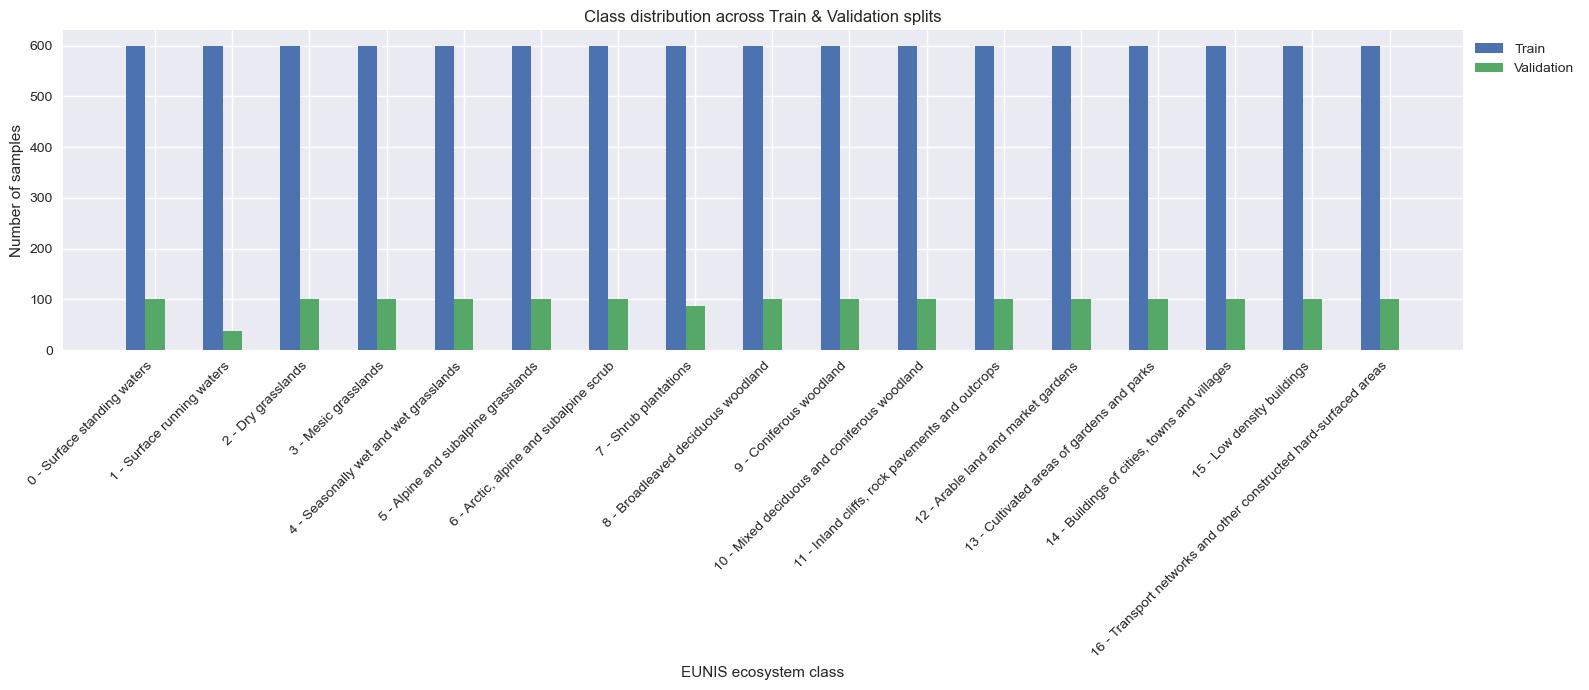

In [5]:
# Count samples per label per split
counts = (df_clean.groupby(['EUNIS_cls', 'EUNIS_label', 'split']).size().unstack(fill_value=0).loc[:, ['train', 'val', 'test']])

# Sort by class number (EUNIS_cls)
counts = counts.sort_index(level=0)

# Plot setup
x = np.arange(len(counts))
width = 0.25

plt.figure(figsize=(16, 7))
plt.bar(x - width, counts['train'], width, label='Train')
plt.bar(x,         counts['val'],   width, label='Validation')

# Rotate labels and show numeric class + label
xticks_labels = [f"{cls} - {label}" for cls, label in counts.index]
plt.xticks(x, xticks_labels, rotation=45, ha='right')

plt.ylabel("Number of samples")
plt.xlabel("EUNIS ecosystem class")
plt.title("Class distribution across Train & Validation splits")

# Place legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

The training set shows an almost uniform distribution across the 17 ecosystem classes, while the validation set exhibits class imbalance, with some underrepresented classes such as Surface running waters (Class 1) and Shrub plantations (Class 7). This imbalance suggests that accuracy alone may be insufficient to properly assess model performance. Therefore, additional evaluation metrics, including macro-averaged F1 score, will be explored in later analyses to ensure balanced performance across all classes.

<a id="36"></a>

### 3.6 Environmental Variables (SWECO25)

The dataset includes 48 numerical variables, standardized to zero mean and unit variance, grouped into thematic categories:
- Bioclimatic
- Edaphic (soil)
- Vegetation
- Land use / land cover (LULC)
- Geology
- Hydrology
- Population and infrastructure

Thematic groupings are used to perform ablation studies.

We inspect the number of variables per SWECO thematic group.

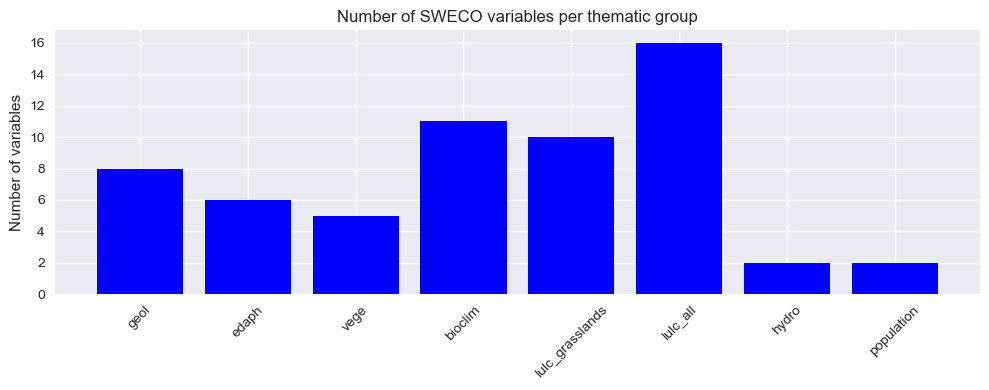

In [6]:
group_counts = {group: len(vars_list) for group, vars_list in sweco_variables_dict.items()}

plt.figure(figsize=(10,4))
plt.bar(group_counts.keys(), group_counts.values(), color='blue')
plt.ylabel("Number of variables")
plt.title("Number of SWECO variables per thematic group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The 48 SWECO variables are unevenly distributed across the thematic groups. Some groups contain only a small number of variables (as few as two), while others are more densely represented, with the largest group comprising up to 16 variables. Most thematic groups include between 5 and 11 variables. This heterogeneous distribution is taken into account when performing ablation studies, as groups with more variables may contribute more strongly to model performance simply due to their higher dimensionality.

<a id="37"></a>

### 3.7 Aerial Images Overview
These high-resolution images capture fine-scale spatial patterns relevant for ecosystem discrimination.

- Source: swissIMAGE (swisstopo)
- Spatial resolution: 50 cm
- Image coverage: 100 × 100 meters
- RGB channels only

We display a few random images from the training set to visualize ecosystem types.

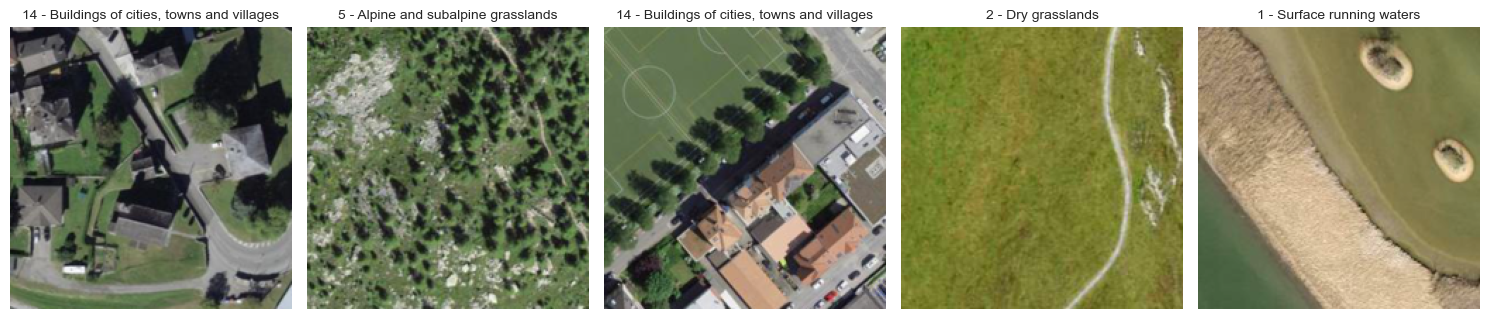

In [7]:
n_samples = 5
sample_rows = train_df.sample(n=n_samples, random_state=SEED)

zip_path = "data/images.zip"

with zipfile.ZipFile(zip_path, 'r') as archive:
    fig, axes = plt.subplots(1, n_samples, figsize=(15,5))
    
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_id = f"{row['id']}.tif"
        label = row['EUNIS_label']
        cls_id = row['EUNIS_cls']
        
        # Load image from zip
        with archive.open(img_id) as file:
            img_bytes = BytesIO(file.read())
            image_array = imread(img_bytes)
        
        # Normalize to [0,1] for plotting
        image_norm = (image_array - image_array.min()) / (image_array.max() - image_array.min())
        
        axes[i].imshow(image_norm)
        axes[i].set_title(f"{cls_id} - {label}", fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

This subset of training images show the difficulty to correctly map Ecosystems to region with changing surface properties.

## 4. Data Preprocessing

<a id="41"></a>

### 4.1 Image Preprocessing

- Image resizing to match model input size
- Normalization using ImageNet statistics
- Data augmentation applied to the training set:
    - Random horizontal and vertical flips
    - Color jitter

These augmentations improve robustness to illumination and orientation variability.

<a id="42"></a>

### 4.2 Tabular Data Preprocessing

- Check missing values in SWECO variables
- Design a function to select subsets by thematic group (bioclim, edaphic, vegetation, etc.)

>**Note** : No standardization is required (the dataset was already standardized)

In [8]:
# Define non-variable columns
non_variable_cols = ['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label']

# All SWECO variables in the dataset
sweco_variables = [col for col in df_clean.columns if col not in non_variable_cols]
print(f"Number of SWECO variables: {len(sweco_variables)}")

# Check missing values
missing_counts = df_clean[sweco_variables].isna().sum()

# Display missing values with friendly message
if missing_counts.sum() == 0:
    print("No missing values across all SWECO variables.")
else:
    print("Missing values per SWECO variable:")
    print(missing_counts[missing_counts > 0])

Number of SWECO variables: 48
No missing values across all SWECO variables.


In [9]:
# Function to select SWECO variables
def get_sweco_features(df, groups=None):
    """
    Select SWECO features from a dataframe.
    
    Parameters:
    - df : pd.DataFrame
    - groups : list of group names (strings) from sweco_variables_dict
               If None, return all SWECO variables.
    
    Returns:
    - X : np.ndarray
    - selected_vars : list of variable names
    """
    non_variable_cols = ['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label']
    
    if groups is None:
        # Return all SWECO variables
        selected_vars = [col for col in df.columns if col not in non_variable_cols]
    else:
        selected_vars = []
        for g in groups:
            if g in sweco_variables_dict:
                selected_vars.extend([v for v in sweco_variables_dict[g] if v in df.columns])
        # Remove duplicates
        selected_vars = list(dict.fromkeys(selected_vars))
    
    X = df[selected_vars].values.astype(np.float32)
    return X, selected_vars

<a id="5"></a>
## 5. Methodology

<a id="51"></a>
### 5.1 Problem Formulation

The task is formulated as a multiclass classification problem with 17 mutually exclusive ecosystem classes.
Inputs:
- RGB aerial image
- Environmental variable vector (optional)

Output:
- Probability distribution over EUNIS classes

---

<a id="52"></a>
### 5.2 Image-Based Model

A convolutional neural network pretrained on ImageNet is used as the image backbone.

- Backbone: ResNet-50 (pretrained)
- Hypercolumn : TRY IT I GUESS
- Transfer learning strategy:
    - Early layers frozen
    - Later layers fine-tuned

- Final classification head:
    - Global average pooling
    - Fully connected layer with 17 outputs

Pretraining provides transferable visual features, which is beneficial given the limited dataset size.

<a id="53"></a>
### 5.3 Tabular-Only Model

To model the environmental variables, we rely on neural networks specifically designed for tabular data. All models take standardized SWECO variables as input and predict one of the 17 ecosystem classes. The architectures are designed to balance expressive power and regularization, given the moderate dimensionality of the input feature space.

**General design choices**

All tabular models share the following characteristics:
- Input: standardized SWECO environmental variables
- Hidden layers: fully connected (dense) layers
- Activation function: ReLU, chosen for its stability and efficiency
- Regularization:
    - Batch Normalization to stabilize training
    - Dropout to reduce overfitting
- Output: a fully connected layer with 17 neurons, followed by a softmax implicitly handled by the cross-entropy loss

#### 5.3.1 Standard Multilayer Perceptron (MLP)

The first architecture is a classical multilayer perceptron (MLP), which serves as a strong baseline for tabular data. The model consists of a sequence of fully connected layers with decreasing dimensionality. This pyramidal structure encourages the network to learn progressively more abstract representations of the input variables.

Batch normalization is applied after each linear transformation to improve convergence, followed by ReLU activation and dropout for regularization.

This architecture is simple, interpretable, and commonly used as a reference model for tabular classification tasks.

In [10]:
class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[512, 256, 128], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

#### 5.3.2 Shallow Multilayer Perceptron (MLP)
A second shallow MLP architecture was tested to evaluate whether a simpler network can achieve comparable performance while reducing the risk of overfitting.

Key differences from the standard MLP:
- Fewer hidden layers and smaller number of neurons per layer.
- Same use of batch normalization, ReLU activations, and dropout.

This helps assess the influence of model complexity on performance.

In [ ]:
class TabularShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 32], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

#### 5.3.3 MLP with Skip Connections (Residual MLP)

While standard MLPs can be effective, deeper networks may suffer from optimization difficulties such as vanishing gradients. To address this, we introduce a second architecture inspired by residual learning, originally proposed for deep convolutional networks.

This model first projects the input features into a fixed-dimensional latent space. It then applies a sequence of residual blocks, where each block learns a transformation that is added to its input. This skip connection allows gradients to flow more easily through the network and encourages the model to learn incremental refinements rather than entirely new representations at each layer.

Residual connections are particularly useful when increasing network depth without significantly degrading performance.

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(dim, dim), nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))


class TabularSkipMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, n_blocks=3, dropout=0.3, n_classes=17):
        super().__init__()

        # Input projection
        self.input_layer = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU())

        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout) for _ in range(n_blocks)])

        # Output head
        self.output_layer = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x)

This function creates PyTorch DataLoaders for training and validation sets. It wraps the input tensors into a TensorDataset and returns DataLoaders with the specified batch size. The training loader is shuffled to improve generalization, while the validation loader preserves the original order.

In [12]:
def make_dataloaders(Xtrain, ytrain, Xval, yval, batch_size=32):
    train_dataset = TensorDataset(Xtrain, ytrain)
    val_dataset   = TensorDataset(Xval, yval)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

<a id="54"></a>
### 5.4 Multimodal Model (Images + Environmental Variables)

A multimodal architecture is designed to combine both data sources:
- Image features extracted using the CNN backbone
- Tabular features extracted using an MLP
- Feature-level fusion by concatenation
- Joint classification head
This approach allows the model to integrate complementary spatial and ecological information.

<a id="55"></a>

### 5.5 Loss Function and Optimization

Ecosystem prediction is a multiclass classification task with mutually exclusive classes.  
We use **categorical cross-entropy** as the loss function. To handle class imbalance, a **class-weighted cross-entropy** can be automatically computed from the training labels.  

The optimizer is **Adam**, optionally with weight decay, and the learning rate can be scheduled during training.  

The following function `get_loss_optimizer` conveniently returns the criterion and optimizer. By setting `weighted=True`, it computes class weights automatically from the training labels.


In [13]:
def get_loss_optimizer(model, ytrain=None, lr=1e-3, weight_decay=0.0, weighted=False):
    """
    Returns a criterion and optimizer for training a model.
    If weighted=True, computes class weights automatically from ytrain.
    
    Args:
        model: torch.nn.Module, the model to optimize
        ytrain: array-like, training labels (required if weighted=True)
        lr: float, learning rate
        weight_decay: float, weight decay for Adam optimizer
        weighted: bool, whether to use class-weighted loss
        
    Returns:
        criterion: loss function
        optimizer: optimizer
    """
    if weighted:
        if ytrain is None:
            raise ValueError("ytrain must be provided when weighted=True")
        classes = np.unique(ytrain)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytrain)
        class_weights = torch.tensor(class_weights, dtype=torch.float32)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    return criterion, optimizer

<a id="6"></a>
## 6. Experimental Design

<a id="61"></a>
### 6.1 Compared Models

The following models are evaluated:
- Image-only model
- Tabular-only model (all SWECO variables)
- Multimodal model (image + all variables)

---

<a id="62"></a>
### 6.2 Ablation Study on Environmental Variables

To assess the contribution of different environmental factors, tabular-only models are trained using:
- Only bioclimatic variables
- Only edaphic variables
- Only vegetation variables
- Only geology variables
- Only land use / land cover variables
- Combined subsets

This analysis identifies which ecological drivers are most informative for ecosystem prediction.

In [14]:
# List of available SWECO groups
available_groups = list(sweco_variables_dict.keys())
print("Available SWECO groups:", available_groups)

Available SWECO groups: ['geol', 'edaph', 'vege', 'bioclim', 'lulc_grasslands', 'lulc_all', 'hydro', 'population']


The code below allows to select the group of variables to train in.

In [15]:
# group selection
group_selection = ['bioclim', 'edaph']

Xtrain_sweco, vars_multi = get_sweco_features(train_df, groups=None)
Xval_sweco, _            = get_sweco_features(val_df, groups=None)

ytrain_sweco = train_df['EUNIS_cls'].values
yval_sweco   = val_df['EUNIS_cls'].values

Xtest_sweco, vars_test = get_sweco_features(test_df, groups=None)
ytest_sweco = test_df['EUNIS_cls'].values

print(f"Number of variables selected: {len(vars_multi)}")
print("Selected variables:", vars_multi)

Number of variables selected: 48
Selected variables: ['bioclim_precipitation', 'bioclim_precipitation_of_driest_quarter', 'bioclim_precipitation_of_wettest_quarter', 'bioclim_maximum_temperature', 'bioclim_minimum_temperature', 'bioclim_mean_temperature_of_driest_quarter', 'bioclim_mean_temperature_of_wettest_quarter', 'bioclim_isothermality_', 'bioclim_temperature_seasonality_(standard_deviation_x100)', 'bioclim_aridity_index', 'bioclim_evapotranspiration', 'lulc_arable_land_100', 'lulc_plantations_fields_and_crops_100', 'lulc_herbaceous_crops_100', 'lulc_woody_plant_crops_100', 'lulc_vineyards_100', 'lulc_meadows_100', 'lulc_wetlands_100', 'lulc_vegetated_shoreline_100', 'lulc_scree_100', 'lulc_roads_rails_paths_100', 'lulc_public_parks_100', 'lulc_high_altitude_grasslands_and_rough_pastures_100', 'lulc_grasslands_and_meadows_100', 'lulc_glaciers_rocks_scree_and_moraines_100', 'lulc_buildings_100', 'lulc_surroundings_of_blocks_of_flats_100', 'edaph_soil_moisture_25.', 'edaph_soil_ph_

The selected SWECO features and target labels are converted into PyTorch tensors:
- Inputs (`X`) are converted to `float32`
- Targets (`y`) are converted to `long` for classification

These tensors can then be directly used with `DataLoader` for batch training.

In [16]:
# --- Convert DataFrames to tensors ---
def df_to_tensor(df, target_col='EUNIS_cls'):
    X = torch.tensor(df.values, dtype=torch.float32)
    return X

Xtrain_tensor = torch.tensor(Xtrain_sweco, dtype=torch.float32)
ytrain_tensor = torch.tensor(ytrain_sweco, dtype=torch.long)

Xval_tensor = torch.tensor(Xval_sweco, dtype=torch.float32)
yval_tensor = torch.tensor(yval_sweco, dtype=torch.long)

Xtest_tensor = torch.tensor(Xtest_sweco, dtype=torch.float32)
ytest_tensor = torch.tensor(ytest_sweco, dtype=torch.long)

<a id="63"></a>

### 6.3 Training Setup and Hyperparameter Selection

The tabular MLP models are trained using a **supervised classification setup** with hyperparameters tuned on the validation set.  

**Explored hyperparameters:**
- Learning rate: {1e-4, 3e-4, 1e-3}
- Batch size: {16, 32}
- Dropout rate: {0.2, 0.5}
- Weight decay: {0, 1e-4}

**Selection criterion:**  
The best configuration is selected based on **validation macro F1-score**, which accounts for class imbalance.  

**Regularization / stopping:**  
- Early stopping is applied to prevent overfitting.
- Dropout is used in the network.
- Weight decay (L2 regularization) is optionally applied in the optimizer.


6.3 Training Setup and Hyperparameter Selection

The tabular MLP models are trained in a **supervised classification setup**, with hyperparameters tuned on the validation set to optimize predictive performance.

**Explored hyperparameters and their effects**:
- Learning rate (1e-4, 3e-4, 1e-3): Controls the step size during gradient descent. Smaller values provide more stable but slower convergence, while larger values can speed up training but risk overshooting minima.
- Batch size (16, 32): Determines the number of samples per gradient update. Smaller batches introduce more noise in gradient estimation, which can improve generalization; larger batches provide more stable updates but may converge to sharper minima.
- Dropout rate (0.2, 0.5): Regularization technique that randomly zeroes a fraction of layer outputs during training. Higher dropout prevents overfitting but can slow convergence.
- Weight decay (0, 1e-4): L2 regularization applied to the network weights to reduce overfitting. Larger values encourage smaller weights and smoother solutions.

**Selection criterion**:
The best configuration is chosen based on validation macro F1-score, which accounts for class imbalance.

**Regularization / stopping**:
- Early stopping is applied to prevent overfitting.
- Dropout and optional weight decay help regularize the network and improve generalization.

**Practical choices for this project**:
To limit the total number of experiments while still exploring key hyperparameter effects, a reduced set of five hyperparameter combinations was selected, covering a range of learning rates, batch sizes, dropout rates, and weight decay. These combinations are used for systematic comparison across model architectures in chapter 8.

In [69]:
hparams_list = [
    {"learning_rate": 1e-4, "batch_size": 16, "dropout_rate": 0.2, "weight_decay": 0},
    {"learning_rate": 1e-4, "batch_size": 32, "dropout_rate": 0.5, "weight_decay": 1e-4},
    {"learning_rate": 3e-4, "batch_size": 16, "dropout_rate": 0.5, "weight_decay": 0},
    {"learning_rate": 1e-3, "batch_size": 32, "dropout_rate": 0.2, "weight_decay": 1e-4},
    {"learning_rate": 1e-3, "batch_size": 16, "dropout_rate": 0.5, "weight_decay": 0}
]

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=100, save_path='best_tabular_model.pt', print_every=10):
    """
    Trains the given model and evaluates on validation set per epoch.
    Stores the model with the best validation F1-score.

    Returns:
        history (dict): Train/validation metrics and epoch times
        best_epoch (int): Epoch with best validation F1
        total_time (float): Total training time in seconds
    """
    best_val_f1 = 0.0
    best_epoch = 0

    history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_acc": [], "val_f1": [], "epoch_time": []}

    total_start = time.time()

    for epoch in range(1, n_epochs + 1):
        start_epoch = time.time()
        model.train()

        train_losses = []
        train_preds, train_labels = [], []

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_preds.append(preds.detach())
            train_labels.append(yb)

        # --- Train metrics ---
        avg_train_loss = sum(train_losses) / len(train_losses)
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)

        train_acc = accuracy_score(train_labels, train_preds.argmax(1))
        train_f1  = f1_score(train_labels, train_preds.argmax(1), average='macro')

        # --- Validation ---
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                val_preds.append(preds)
                val_labels.append(yb)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_acc = accuracy_score(val_labels, val_preds.argmax(1))
        val_f1  = f1_score(val_labels, val_preds.argmax(1), average='macro')

        # --- Save best ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)

        # --- Store history ---
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["epoch_time"].append(time.time() - start_epoch)

        if epoch % print_every == 0 or epoch == 1:
            print(
                f"Epoch {epoch}/{n_epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Train Acc: {train_acc:.3f}, Train F1: {train_f1:.3f} | "
                f"Val Acc: {val_acc:.3f}, Val F1: {val_f1:.3f}"
            )

    total_time = time.time() - total_start

    return history, best_epoch, total_time

<a id="7"></a>
## 7. Evaluation Metrics
<a id="71"></a>
### 7.1 Classification Metrics

The following metrics are computed on train, validation, and test sets:
- Overall accuracy
- Macro-averaged F1-score
- Per-class F1-score
- Confusion matrix

Macro-averaged metrics are emphasized to ensure fair evaluation of rare ecosystem classes.

In [19]:
def evaluate_model(model, X, y):
    """
    Compute the accuracy, macro averaged F1-score and per-class F1-score
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        preds = outputs.argmax(1)

    acc = accuracy_score(y, preds)
    f1_macro  = f1_score(y, preds, average='macro')
    f1_per_class = f1_score(y, preds, average=None)

    return acc, f1_macro, f1_per_class

In [34]:
def plot_per_class_f1(f1_per_class, class_labels=None, title="Per-Class F1 Score"):
    """
    Plot per-class F1 scores, showing class number and name.

    Args:
        f1_per_class (array-like): F1 score for each class
        class_labels (list): Optional class names
        title (str): Plot title
    """
    n_classes = len(f1_per_class)
    if class_labels is None:
        class_labels = [f"{i+1}" for i in range(n_classes)]
    else:
        # Combine class number and name
        class_labels = [f"{i+1}. {name}" for i, name in enumerate(class_labels)]
    
    plt.figure(figsize=(12,6))
    plt.bar(np.arange(n_classes), f1_per_class, color='skyblue')
    plt.xticks(np.arange(n_classes), class_labels, rotation=90)
    plt.ylabel("F1 Score")
    plt.xlabel("Class")
    plt.title(title)
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [21]:
def plot_confusion_matrix(y_true, y_pred, class_labels, figsize=(10,10), normalize=True, cmap='Blues', title="Confusion Matrix"):
    """
    Plots the confusion matrix.
    
    Args:
        y_true: array-like, true labels
        y_pred: array-like, predicted labels
        class_labels: list of label names
        figsize: tuple, figure size
        normalize: bool, whether to show percentages
        cmap: colormap
        title: figure title
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=cmap, values_format=fmt, xticks_rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_training_curves(history, save_path=None):
    epochs = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", linewidth=1)
    plt.plot(epochs, history["val_acc"], label="Val Accuracy", linewidth=1)
    plt.plot(epochs, history["train_f1"], '--', label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], '--', label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Training and Validation Performance")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")    
    plt.show()

<a id="72"></a>
### 7.2 Computational Performance

Computational efficiency is assessed by measuring:
- Average training time per epoch
- Total training time
- Inference time per sample

In [23]:
def measure_inference_time(model, X):
    model.eval()
    with torch.no_grad():
        start = time.time()
        _ = model(X)
        total_time = time.time() - start
    return total_time / len(X)

IDK WHERE TO PUT THIS FOR NOW

In [24]:
def log_experiment(file_path, experiment_dict):
    # Ensure all keys exist in the dict and fill missing with NaN
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        df = pd.DataFrame(columns=experiment_dict.keys())

    # Fill any missing keys with NaN to match existing columns
    for col in df.columns:
        if col not in experiment_dict:
            experiment_dict[col] = pd.NA

    # Append the new experiment (overwrite if same combination)
    mask = (
        (df['model_name'] == experiment_dict['model_name']) &
        (df['dropout_rate'] == experiment_dict['dropout_rate']) &
        (df['learning_rate'] == experiment_dict['learning_rate']) &
        (df['batch_size'] == experiment_dict['batch_size']) &
        (df['weight_decay'] == experiment_dict['weight_decay']) &
        (df['weighted_ce'] == experiment_dict['weighted_ce'])
    )
    df = df[~mask]  # remove previous entry if same combination
    df = pd.concat([df, pd.DataFrame([experiment_dict])], ignore_index=True)
    
    df.to_csv(file_path, index=False)

<a id="8"></a>
## 8. Hyperparameter & Model Exploration
<a id="81"></a>
### 8.1 Quantitative Results on Training and Validation Set

Model : TabularShallowMLP
Hyperparameters used : {'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.2, 'weight_decay': 0}
Epoch 1/100 | Train Loss: 2.5478 | Train Acc: 0.226, Train F1: 0.200 | Val Acc: 0.375, Val F1: 0.330
Epoch 10/100 | Train Loss: 1.4674 | Train Acc: 0.515, Train F1: 0.502 | Val Acc: 0.524, Val F1: 0.481
Epoch 20/100 | Train Loss: 1.3404 | Train Acc: 0.550, Train F1: 0.541 | Val Acc: 0.538, Val F1: 0.510
Epoch 30/100 | Train Loss: 1.2959 | Train Acc: 0.559, Train F1: 0.552 | Val Acc: 0.534, Val F1: 0.504
Epoch 40/100 | Train Loss: 1.2664 | Train Acc: 0.570, Train F1: 0.563 | Val Acc: 0.530, Val F1: 0.498
Epoch 50/100 | Train Loss: 1.2450 | Train Acc: 0.579, Train F1: 0.573 | Val Acc: 0.539, Val F1: 0.514
Epoch 60/100 | Train Loss: 1.2280 | Train Acc: 0.577, Train F1: 0.570 | Val Acc: 0.535, Val F1: 0.506
Epoch 70/100 | Train Loss: 1.2088 | Train Acc: 0.586, Train F1: 0.581 | Val Acc: 0.541, Val F1: 0.519
Epoch 80/100 | Train Loss: 1.1932 | Train Acc: 0.589

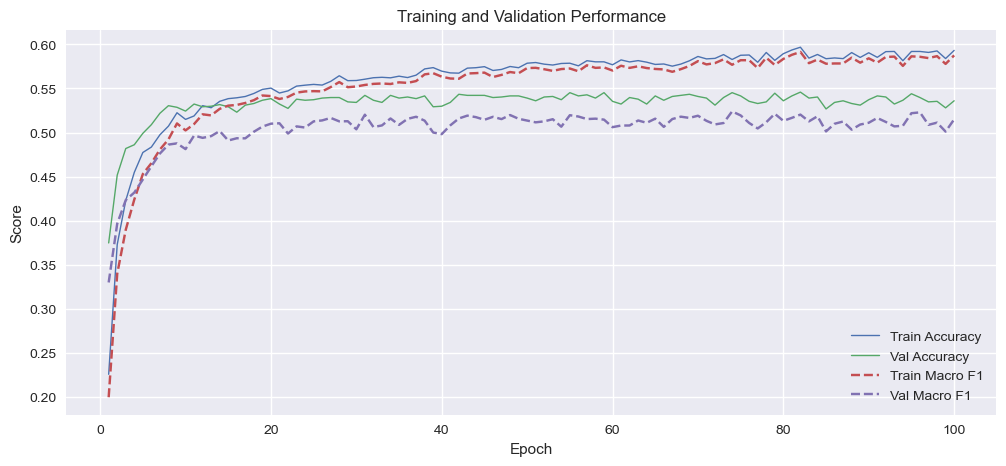

In [68]:
# === Section 8: Run experiment ===

# 0. Selection of hyperparmeters and number of epochs
hparams = hparams_list[0]

# maxmimum number of epochs
n_epochs = 100

# weighted cross entropy
weighted = False

# 1. Dataloaders
train_loader, val_loader = make_dataloaders(Xtrain_tensor, ytrain_tensor, Xval_tensor, yval_tensor, batch_size=hparams['batch_size'])

# 2. Model
input_dim = Xtrain_tensor.shape[1]

#model = TabularSkipMLP(input_dim=input_dim, hidden_dim=256, n_blocks=3, dropout=hparams["dropout_rate"], n_classes=17)
#model = TabularMLP(input_dim=input_dim, hidden_layers = [512,256,128], dropout=hparams['dropout_rate'], n_classes=17)
model = TabularShallowMLP(input_dim=input_dim, hidden_layers = [128,32], dropout=hparams['dropout_rate'], n_classes=17)

# ---- Experiment naming ---- # 
model_name = model.__class__.__name__
experiment_name = f"{model_name}_tabular"
model_path = f"models/{experiment_name}.pt"
plot_path  = f"figures/{experiment_name}_training.png"

print(f'Model : {model_name}')
print(f'Hyperparameters used : {hparams}')

# 3. Loss & optimizer (weighted or not)
criterion, optimizer = get_loss_optimizer(model, ytrain=ytrain_tensor.numpy(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'], weighted=weighted)

# 4. Train
history, best_epoch, total_time = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=n_epochs, print_every=10, save_path=model_path)

# 5. Load best model
model.load_state_dict(torch.load(model_path))

# 6. Evaluate on validation
val_acc, val_f1, val_f1_per_class = evaluate_model(model, Xval_tensor, yval_tensor)

print("\n=== Model performance ===")
print(f"Best epoch: {best_epoch}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Macro F1: {val_f1:.4f}")

# 7. Display computational performance
avg_epoch_time = total_time / n_epochs
print("\n=== Computational Performance ===")
print(f"Total training time: {total_time:.2f} s")
print(f"Average training time per epoch: {avg_epoch_time:.2f} s")

# 8. Plot
plot_training_curves(history, save_path=plot_path)

# 9. Saving all the parameters and results in a CSV
experiment_log = {
    "model_name": model.__class__.__name__,
    "dropout_rate": hparams['dropout_rate'],
    "learning_rate": hparams['learning_rate'],
    "batch_size": hparams['batch_size'],
    "weight_decay": hparams['weight_decay'],
    "weighted_ce": weighted,
    "best_epoch": best_epoch,
    "val_acc": val_acc,
    "val_macro_f1": val_f1,
    "total_time_s": total_time,
    "avg_epoch_time_s": avg_epoch_time
}

log_experiment("experiment_log.csv", experiment_log)

<a id="83"></a>
### 8.2 Best model choice

The following code loads the previous results and retrieve the best combination of hyperparameter by model. It allows us to retrieve the best model by architecture and to easily compare them.

In [70]:
# Load experiment log
log_path = "experiment_log.csv"

if os.path.exists(log_path):
    experiments_df = pd.read_csv(log_path)
    
    # Select the best experiment per model based on validation Macro F1
    best_per_model = experiments_df.loc[experiments_df.groupby('model_name')['val_macro_f1'].idxmax()]

    # Sort by model name for display
    best_per_model = best_per_model.sort_values(by='model_name')
    
    print("Best hyperparameter combination per model:")
    display(best_per_model.sort_values(by='val_macro_f1', ascending=False))
else:
    print(f"No log file found at {log_path}")

Best hyperparameter combination per model:


,model_name,dropout_rate,learning_rate,batch_size,weight_decay,...,best_epoch,val_acc,val_macro_f1,total_time_s,avg_epoch_time_s
0,TabularMLP,0.2,0.0001,16,0.0,...,44,0.564923,0.561250,337.662071,3.376621
2,TabularSkipMLP,0.2,0.0001,16,0.0,...,17,0.559385,0.557689,672.446912,6.724469
5,TabularShallowMLP,0.2,0.0001,16,0.0,...,90,0.550154,0.530350,314.999016,3.149990


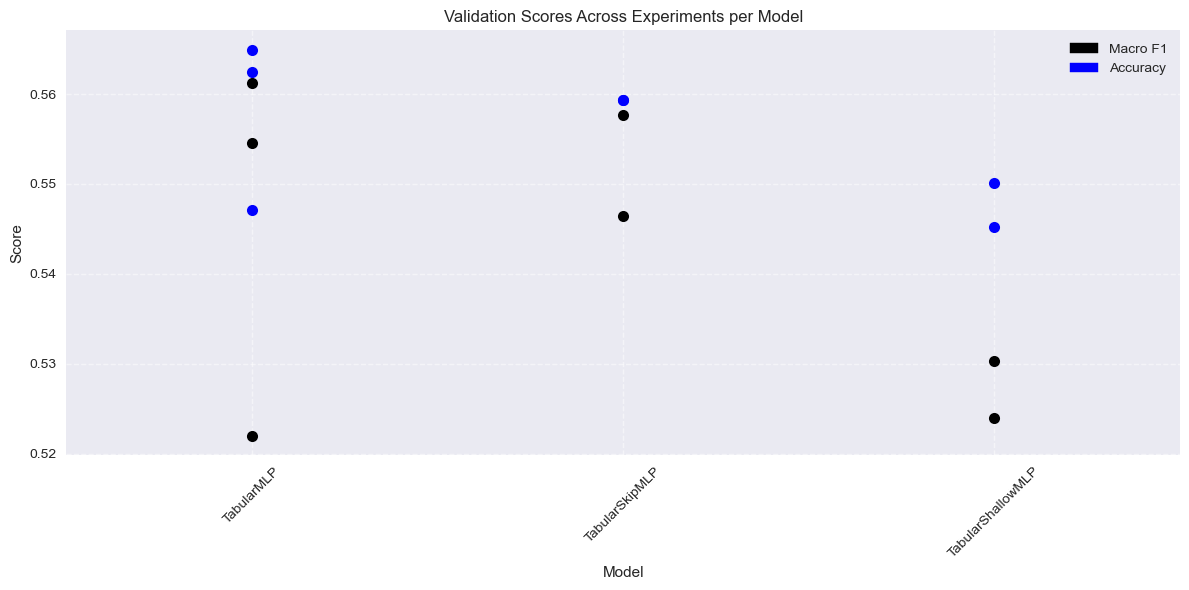

In [71]:
if os.path.exists(log_path):
    experiments_df = pd.read_csv(log_path)
    
    plt.figure(figsize=(12,6))
    
    # Strip plot for Macro F1
    sns.stripplot(data=experiments_df, x='model_name', y='val_macro_f1', jitter=False, size=8, color='black')
    
    # Strip plot for Accuracy
    sns.stripplot(data=experiments_df, x='model_name', y='val_acc', jitter=False, size=8, color='blue')

    # Create custom legend
    black_patch = mpatches.Patch(color='black', label='Macro F1')
    blue_patch  = mpatches.Patch(color='blue', label='Accuracy')
    plt.legend(handles=[black_patch, blue_patch])

    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.title("Validation Scores Across Experiments per Model")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print(f"No log file found at {log_path}")

Rerun with the best model found and stored the model with save_path = 'best_model.pt'

<a id="9"></a>
## 9 Quantitative Results on Test Set

<a id="91"></a>
### 9.1 Quantitative Results on Test Set

- Performance comparison of all models
- Summary table of metrics

Test Set Results
Accuracy: 0.5863
Macro F1: 0.5786
Inference time per sample: 0.0005 ms


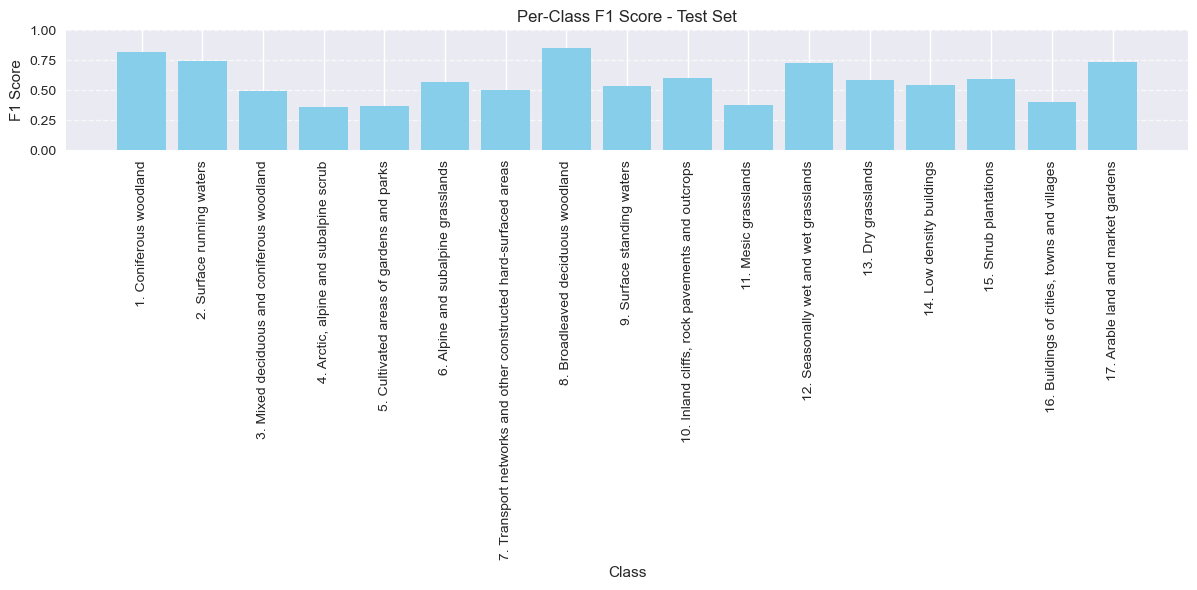

In [64]:
# Load best model
model.load_state_dict(torch.load(model_path))

# Test (final results)
test_acc, test_f1, test_f1_per_class = evaluate_model(model, Xtest_tensor, ytest_tensor)
test_inf_time = measure_inference_time(model, Xtest_tensor)

print("Test Set Results")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1: {test_f1:.4f}")
print(f"Inference time per sample: {test_inf_time*1000:.4f} ms")

# Plot per-class F1
plot_per_class_f1(test_f1_per_class, class_labels=test_df['EUNIS_label'].unique(), 
                   title="Per-Class F1 Score - Test Set")

<a id="92"></a>
### 9.2 Impact of Environmental Variable Groups (MAYBE THE SAME AS LATER??)

- Performance comparison across thematic groups
- Visualization of ablation study results

<a id="93"></a>
### 9.3 Image vs Environmental Variables

- Comparison of image-only and tabular-only models
- Performance gains from multimodal fusion

<a id="9"></a>
## 9. Visual Analysis (I guess with the best model at the very end)
<a id="94"></a>
### 9.4 Confusion Matrices

- Best-performing model
- Analysis of frequent misclassifications

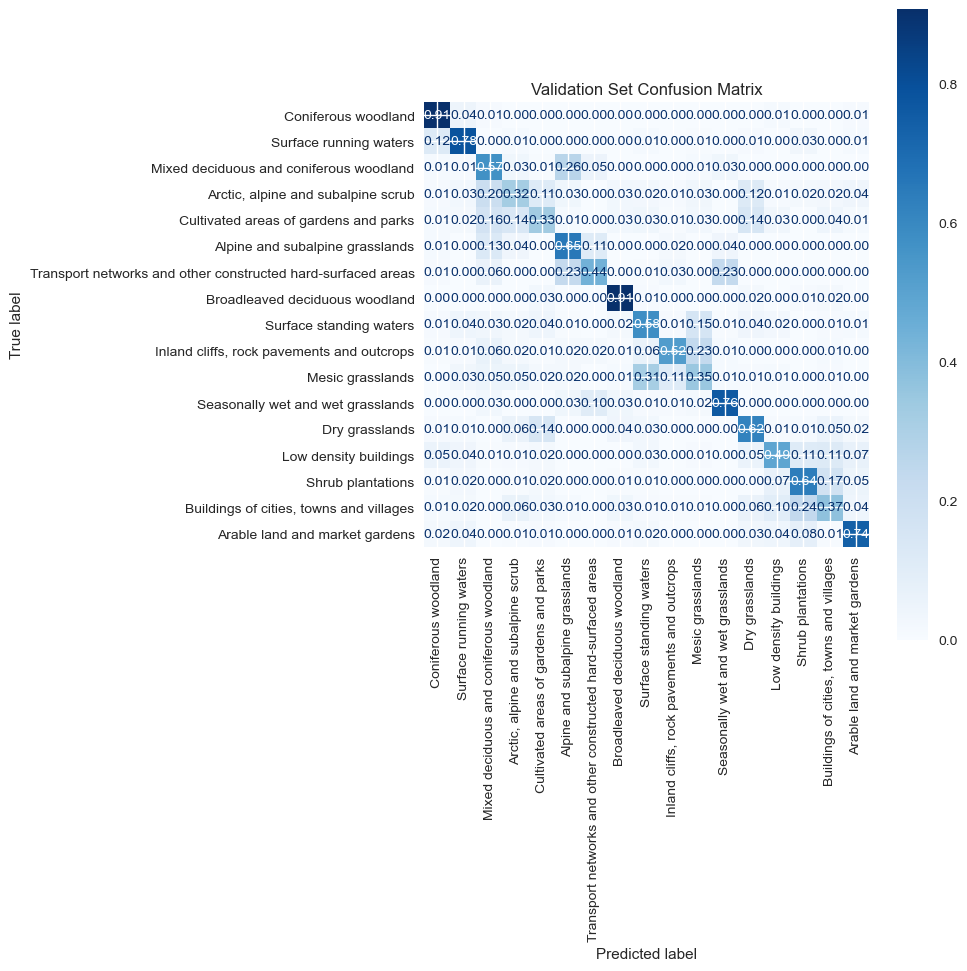

In [65]:
# --- Evaluate on test set ---
model.eval()
with torch.no_grad():
    test_outputs = model(Xtest_tensor)
    test_pred_labels = torch.argmax(test_outputs, dim=1)

# Plot confusion matrix
plot_confusion_matrix(y_true=ytest_tensor, y_pred=test_pred_labels,
                      class_labels=test_df['EUNIS_label'].unique(), title="Validation Set Confusion Matrix")

<a id="95"></a>
### 9.5 Feature Importance Analysis

- Sensitivity or permutation-based importance for tabular variables
- Interpretation in ecological context

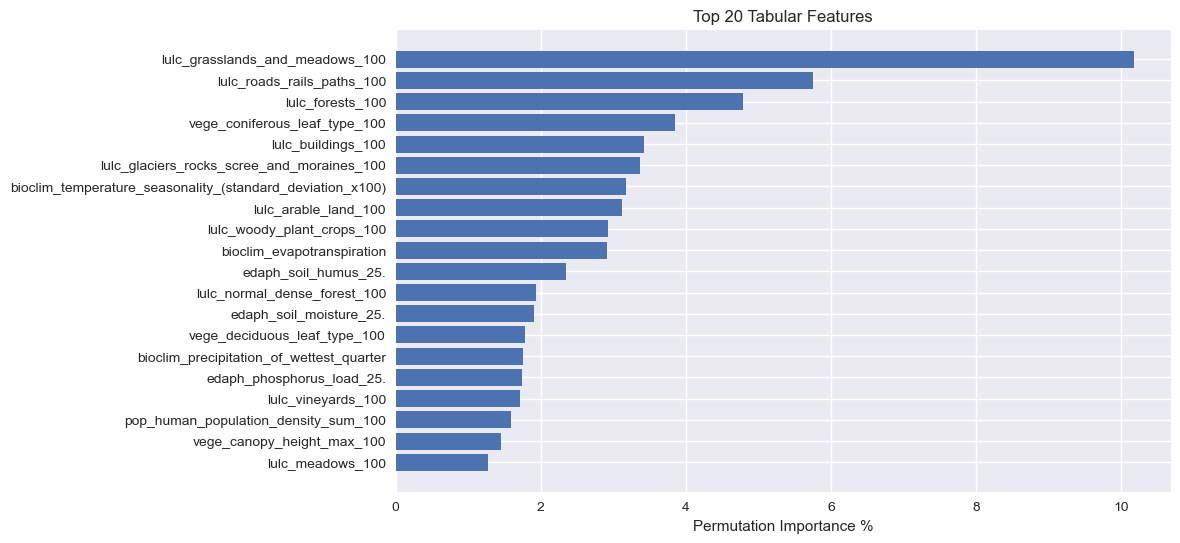

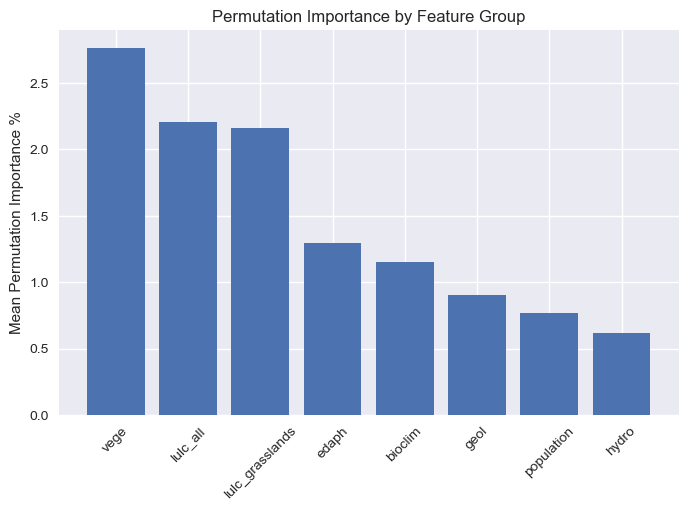

In [66]:
def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=5):
    base_preds = torch.argmax(model(X), dim=1)
    base_score = metric(y, base_preds)
    
    importances = np.zeros(X.shape[1])
    
    for col in range(X.shape[1]):
        scores = []
        X_permuted = X.clone()
        for _ in range(n_repeats):
            perm = torch.randperm(X.shape[0])
            X_permuted[:, col] = X_permuted[perm, col]
            preds = torch.argmax(model(X_permuted), dim=1)
            scores.append(base_score - metric(y, preds))
        importances[col] = np.mean(scores)
    
    return importances

# Compute feature-level permutation importance
feature_importances = permutation_importance(model, Xtest_tensor, ytest_tensor)

# Convert to percentage (accuracy points)  % drop in metrics
feature_importances_pct = feature_importances * 100  

# Aggregate by group
group_importances = {}
for group_name, group_features in sweco_variables_dict.items():
    idx = [i for i, f in enumerate(vars_multi) if f in group_features]
    if len(idx) > 0:
        group_importances[group_name] = feature_importances_pct[idx].mean()
    else:
        group_importances[group_name] = 0.0

# Plot top 20 individual features
top_idx = np.argsort(feature_importances_pct)[-20:][::-1]
plt.figure(figsize=(10,6))
plt.barh(range(20), feature_importances_pct[top_idx])
plt.yticks(range(20), np.array(vars_multi)[top_idx])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance %")
plt.title("Top 20 Tabular Features")
plt.show()

# Plot group-level importances
plt.figure(figsize=(8,5))
groups_sorted = sorted(group_importances.items(), key=lambda x: x[1], reverse=True)
plt.bar([g[0] for g in groups_sorted], [g[1] for g in groups_sorted])
plt.xticks(rotation=45)
plt.ylabel("Mean Permutation Importance %")
plt.title("Permutation Importance by Feature Group")
plt.show()

<a id="96"></a>
### 9.6 Spatial Visualization

- Map predictions over Switzerland
- Compare predicted vs true ecosystems

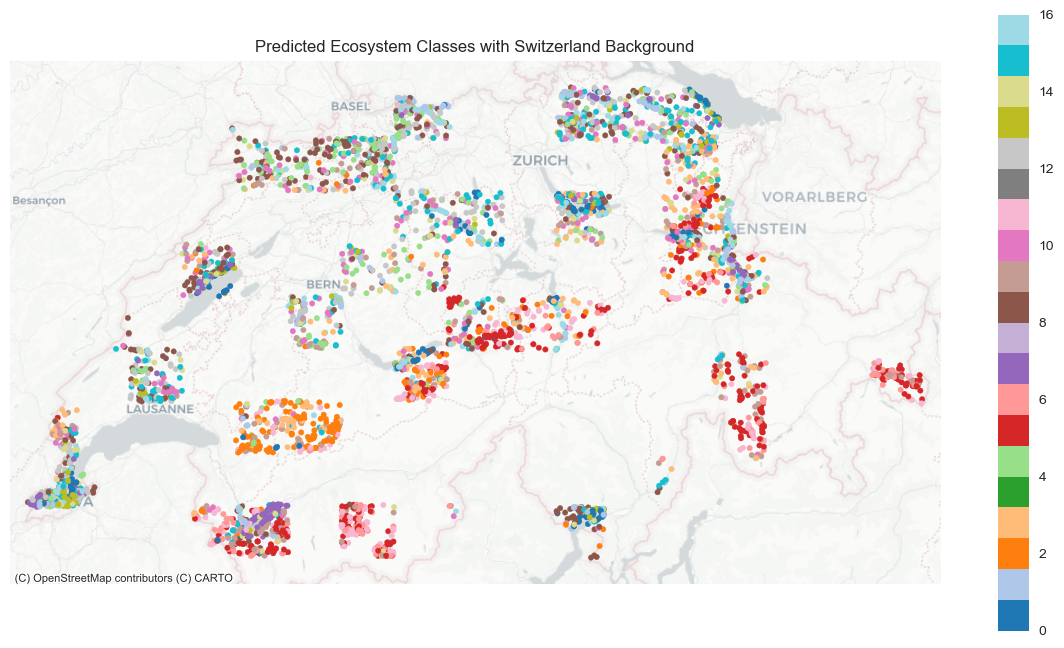

In [38]:
# Add predictions to your GeoDataFrame
test_df['pred_class'] = test_pred_labels  # numpy array is fine

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(test_df['x'], test_df['y'])]
test_points = gpd.GeoDataFrame(test_df, geometry=geometry, crs="EPSG:2056")

# Project to web mercator
test_points = test_points.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(15,8))
test_points.plot(ax=ax, column='pred_class', cmap='tab20', markersize=15, legend=True)

# Add basemap
ax.set_xlim(test_points.total_bounds[0]-10000, test_points.total_bounds[2]+10000)
ax.set_ylim(test_points.total_bounds[1]-15000, test_points.total_bounds[3]+15000)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.title("Predicted Ecosystem Classes with Switzerland Background")
plt.show()

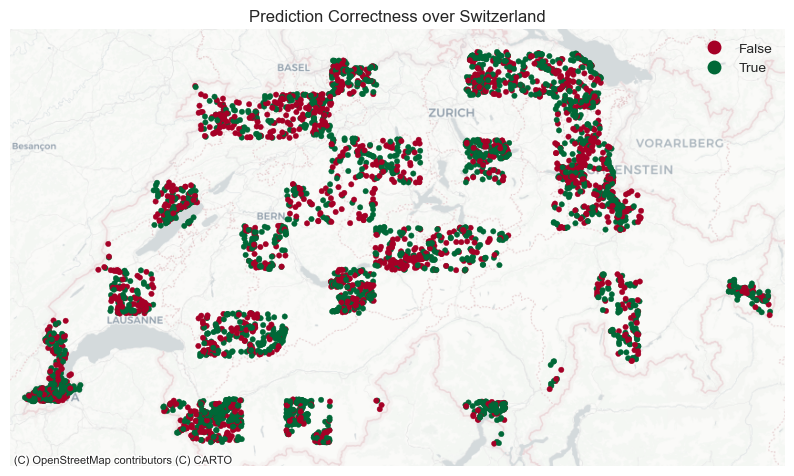

In [39]:
# --- Determine correctness ---
# True labels
true_labels = ytest_tensor.numpy()
# Predicted labels
pred_labels = test_pred_labels.numpy()
# Boolean array: True if correct, False if wrong
correct = true_labels == pred_labels

# Convert test coordinates to GeoDataFrame
geometry = [Point(xy) for xy in zip(test_df['x'], test_df['y'])]
test_points = gpd.GeoDataFrame(test_df, geometry=geometry, crs="EPSG:2056")

# Add a column for correctness
test_points['correct'] = correct

# Project to Web Mercator for contextily tiles
test_points = test_points.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10,10))

# Correct predictions in green, incorrect in red
test_points.plot(ax=ax, column='correct', cmap='RdYlGn', markersize=15, legend=True)

# Optional: add basemap for context
ax.set_xlim(test_points.total_bounds[0]-10000, test_points.total_bounds[2]+10000)
ax.set_ylim(test_points.total_bounds[1]-15000, test_points.total_bounds[3]+15000)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.title("Prediction Correctness over Switzerland")
plt.show()


<a id="10"></a>
## 10. Discussion (probably in the report)
<a id="101"></a>
### 10.1 Key Findings

- Main performance trends
- Complementarity between imagery and environmental variables

---

<a id="102"></a>
### 10.2 Scientific Interpretation

- Ecological meaning of important predictors
- What information imagery cannot capture alone

---

<a id="103"></a>
### 10.3 Limitations

- Class imbalance
- Spatial resolution constraints
- Model interpretability
- Limited temporal variability

<a id="11"></a>
## 11. Conclusion and Future Work (probably in the report)

- Summary of contributions
- Potential methodological improvements
- Future data extensions

<a id="12"></a>
## 12. Reproducibility (remove or move somewhere else)
<a id="121"></a>
### 12.1 Code Organization

- Notebook structure
- Scripts and modules used

---

<a id="122"></a>
### 12.2 How to Run

- Required libraries
- Hardware assumptions
- Random seed control

<a id="13"></a>
## 13. References